In [17]:
import torch 
# import torchvision
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

from pathlib import Path
# import csv
import numpy as np
import cv2
from tqdm import tqdm

# from edge_detection import edgeDetection
# from interest_point_detection import display_interest_points_matrix
# from detect_laser import *
# from torchinfo import summary
# from torchmetrics.classification import BinaryAccuracy

import matplotlib.pyplot as plt
# from multiprocessing import Pool, cpu_count
from skimage.feature import peak_local_max
from detect_laser import get_masked_image_matrix, get_vanishing_point

In [8]:
def get_tiles(img, coordinates):
    # takes in gray-scale image
    # get 20 by 20 tiles that are centred around the points in coordinates
    N = 20
    M = 20
    buf = []
    coords_buf = []
    img_tiles = [img[int(x-M/2):int(x+M/2),int(y-N/2):int(y+N/2),:] for x,y in coordinates]
    for i, tile in enumerate(img_tiles):
        if tile.shape == (N, M, 3):
            buf.append(np.reshape(tile, (3,N,M)))
            coords_buf.append(coordinates[i])
    coordinates = np.asarray(coords_buf)
    img_tiles = np.asarray(buf)
    print(img_tiles.shape)
    return img_tiles, coordinates

In [9]:
# file = Path("data/for viva/P8030247.PNG")
# img = cv2.imread(file.as_posix())
# calib1 = Path("old_configs/FSL-01D/fsl-01d-lens-raw.dat")
# lcalib1 = Path("old_configs/FSL-01D/laser-calibration.pkg")

# masked_img, _ = get_masked_image_matrix(lcalib1, calib1, img)
# # coordinates_masked = peak_local_max(masked_img[:,:,2], threshold_abs=170, min_distance=20)
# coordinates = peak_local_max(img[:,:,2], threshold_abs=170, min_distance=20)

In [10]:
# plt.imshow(img, cmap="gray")
# plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# plt.show()

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2))
        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3200, 10)
        self.act2 = nn.ReLU()

        self.linear2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        
        x = self.flatten(x)
        x = self.act2(self.linear1(x))

        x = self.linear2(x)
        
        return x

In [13]:
model = Net()
load_path = Path("old_binary_pth/model_binary469.pth")
model.load_state_dict(torch.load(load_path.as_posix()))

<All keys matched successfully>

In [14]:
# tiles, coords = get_tiles(img, coordinates)

In [15]:
# model.eval()
# preds = model(torch.Tensor(tiles))
# possible = F.sigmoid(preds) > .99 

# possible_coords = coords[possible.reshape(1, -1)[0]]
# allowed_coords = []
# final_coord = []
# vanishing_point = get_vanishing_point(lcalib1, calib1)[:2]

# for i in range(possible_coords.shape[0]):
#     coord = possible_coords[i,:]

#     if np.any(masked_img[coord[0], coord[1]]):
        
#         allowed_coords.append([coord[0], coord[1]])
    
#     # allowed_coords.append(masked_img[coord[0], coord[1]])

# min_distance = 1000000000
# for coord in allowed_coords:
#     distance = np.linalg.norm(coord-vanishing_point)
#     if ( distance < min_distance):
#         final_coord = coord
#         min_distance = distance
    
# allowed_coords = np.array(allowed_coords)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.imshow(img_rgb)
# plt.plot(possible_coords[:,1], possible_coords[:, 0], 'g.')
# plt.plot(allowed_coords[:,1], allowed_coords[:, 0], 'b.')
# plt.plot(final_coord[1], final_coord[0], 'r.')
# plt.show()

1: data/png/ED-00/FSL-05D/LaserCalibration/P8140001.png


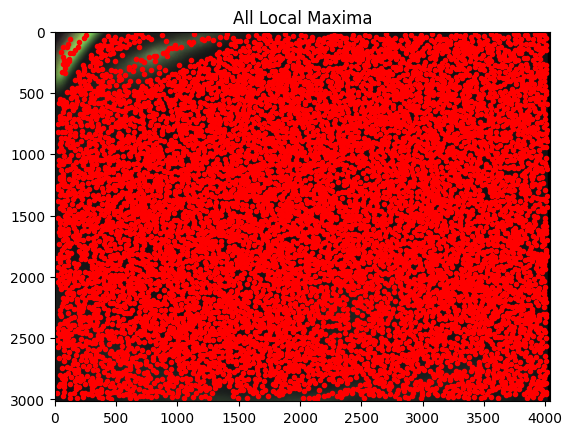

(8312, 3, 20, 20)
(1, 2)


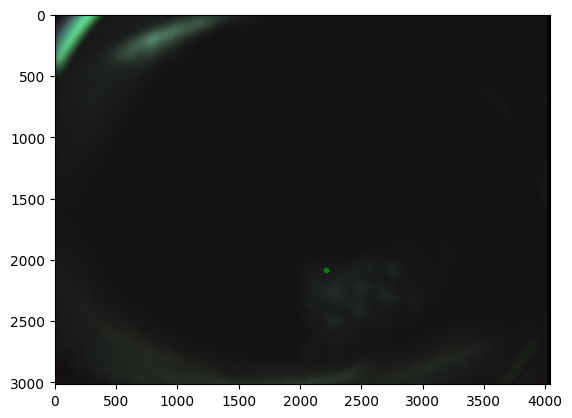

2: data/png/ED-00/FSL-05D/LaserCalibration/P8140002.png


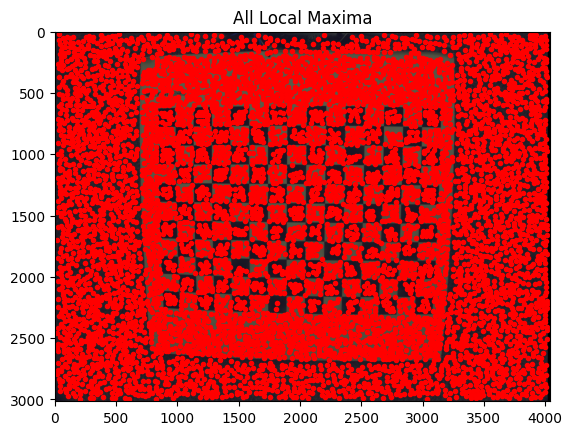

(7512, 3, 20, 20)
(1, 2)


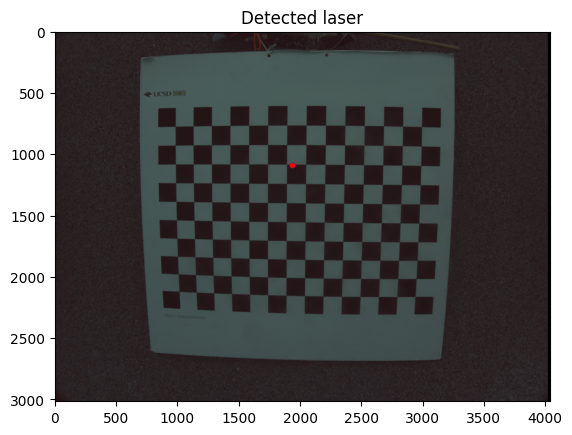

In [18]:
directory = Path("data/png/ED-00/FSL-05D/LaserCalibration")
files = list(directory.glob("*.PNG"))
files.extend(list(directory.glob("*.png")))

show_local_maxima = True
for i, file in enumerate(sorted(files)):

    img = cv2.imread(file.as_posix())
    calib1 = Path("old_configs/FSL-05D/fsl-05d-lens-png.pkg")
    lcalib1 = Path("old_configs/FSL-05D/laser-calibration.pkg")
    print(f"{i+1}: {file.as_posix()}")
    masked_img, _ = get_masked_image_matrix(lcalib1, calib1, img)
    # coordinates_masked = peak_local_max(masked_img[:,:,2], threshold_abs=170, min_distance=20)
    coordinates = peak_local_max(img[:,:,2], min_distance=20)

    if show_local_maxima:
        plt.title("All Local Maxima")
        plt.imshow(img, cmap="gray")
        plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
        plt.show()
        
    tiles, coords = get_tiles(img, coordinates)
    model.eval()

    if len(tiles) == 0:
        print("No local maxima found")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        # plt.plot(possible_coords[:,1], possible_coords[:, 0], 'g.')
        # plt.plot(allowed_coords[:,1], allowed_coords[:, 0], 'b.')
        # plt.plot(final_coord[1], final_coord[0], 'r.')
        plt.show()
        continue
        
    preds = model(torch.Tensor(tiles))
    possible = F.sigmoid(preds) > .99
    possible_coords = []

    for i in range(coords.shape[0]):
        if possible[i]:
            possible_coords.append(coords[i,:])

    possible_coords = np.array(possible_coords)
    print(possible_coords.shape)
    # try:
    #     possible_coords = coords[possible.reshape(1, -1)[0]]

    # except:
    #     possible_coords = coords

    if len(possible_coords)==0:
        print("there are no possible points")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        # plt.plot(possible_coords[:,1], possible_coords[:, 0], 'g.')
        # plt.plot(allowed_coords[:,1], allowed_coords[:, 0], 'b.')
        # plt.plot(final_coord[1], final_coord[0], 'r.')
        plt.show()
        continue
    
    allowed_coords = []
    final_coord = []
    vanishing_point = get_vanishing_point(lcalib1, calib1)[:2]
    
    for i in range(possible_coords.shape[0]):
        coord = possible_coords[i,:]
    
        if np.any(masked_img[coord[0], coord[1]]):
            
            allowed_coords.append([coord[0], coord[1]])
        
        # allowed_coords.append(masked_img[coord[0], coord[1]])

    if len(allowed_coords) == 0:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.plot(possible_coords[:,1], possible_coords[:, 0], 'g.')
        # plt.plot(allowed_coords[:,1], allowed_coords[:, 0], 'b.')
        # plt.plot(final_coord[1], final_coord[0], 'r.')
        plt.show()
        continue
    min_distance = 1000000000
    for coord in allowed_coords:
        distance = np.linalg.norm(coord-vanishing_point)
        if ( distance < min_distance):
            final_coord = coord
            min_distance = distance
        
    allowed_coords = np.array(allowed_coords)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img_rgb)
    plt.title("Detected laser")
    plt.plot(possible_coords[:,1], possible_coords[:, 0], 'g.')
    plt.plot(allowed_coords[:,1], allowed_coords[:, 0], 'b.')
    plt.plot(final_coord[1], final_coord[0], 'r.')
    plt.show()
    
    break